In [89]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
import warnings

from modules.salvoimport import load_salvo_data_str, load_gml_albedo
from modules.salvoproc import line_date_agg

In [45]:
# Set matplotlib font parameters
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 32}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 5

# Set start and end dates for all plots
start_date = pd.Timestamp('2024-05-22T00:00:00-0800')
end_date = pd.Timestamp('2024-06-19T00:00:00-0800')

In [46]:
# Load SALVO data
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile', 'magnaprobe'], sites=['arm', 'beo', 'ice'])

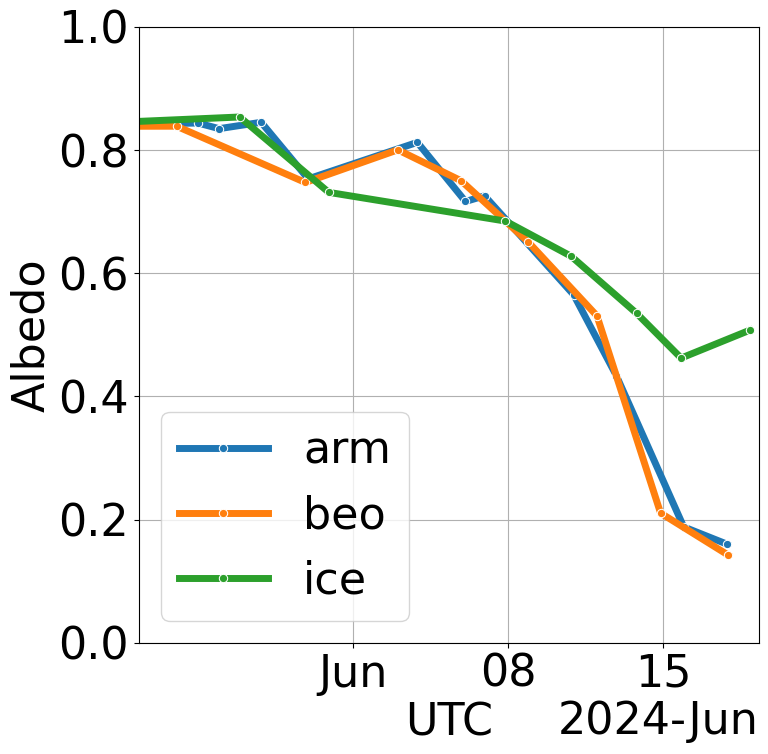

In [47]:
# Plot Albedo evolution

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# Line
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='albedo', hue='site', ax=ax,
            marker='o')

ax.set_xlim([start_date, end_date])
ax.set_ylim(0, 1.0)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('UTC')

ax.set_ylabel('Albedo')
ax.grid()

ax.legend()

f.savefig(os.path.join('..','figures','amss_albedo_2025.png'), bbox_inches='tight')

In [48]:
# Load snowpit stratigraphy table
df = pd.read_excel(os.path.join(salvo_data_root_path, 'salvo_2024_snowpit_stratigraphy.xlsx'), 
                   header=[0,1], index_col=[0,1,2,3], parse_dates=True, date_format='YYYY-MM-DD')

# Drop incomplete columns
df.drop(columns=[(     'Postprocessed',          'TEMP Thickness (cm)'),
                (     'Postprocessed',              'Density (kg/m3)'),
                (     'Postprocessed',   'LAI (b.c. equivalent ng/g)'),
                (     'Postprocessed', 'LAI (b.c. equivalent ng/g).1')],
        inplace=True)

In [49]:
df.xs(('2024-06-07 00:00:00', 0), level=(0, 3))

Field Observations                              \
Position                        Pit Name Layer Name (field) Top (cm)   
ice ice-20240607-a  three shades of snow                Sfc      5.0   
    ice-20240607-a  three shades of snow                  A      5.0   
    ice-20240607-a  three shades of snow             Bottom      0.0   

                                                     \
Position           Bottom (cm) Grain Shape Hardness   
ice ice-20240607-a         5.0         NaN      NaN   
    ice-20240607-a         0.0  MFpc(IFbi)      NaN   
    ice-20240607-a         0.0         NaN      NaN   

                                                        Postprocessed  \
Position                                          Notes         Notes   
ice ice-20240607-a                                  NaN           NaN   
    ice-20240607-a  very porous, coarse grained "snow"?           NaN   
    ice-20240607-a             lump mounded ice surface           NaN   

                                               
Position           Layer Name (postprocessed)  
ice ice-20240607-a                        NaN  
    ice-20240607-a                        NaN  
    ice-20240607-a                        NaN

In [54]:
gs = 'IFpc(MFsl)'
gs = 'IFpc'
print(gs.split('('))

['IFpc']


In [85]:
def plot_snowpit_column(ax, df, key):

    # Get requested pit
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message='indexing past lexsort depth may impact performance.')
        df_plot = df.loc[key]

    # Dictionary relating grain type and color
    grain_color = {
        'MF': '#FF0000',
        'IF': '#00FFFF',
                  }

    for idx, row in df_plot.iterrows():
        # Check whether this is an interface or a layer
        top = row[('Field Observations', 'Top (cm)')]
        bot = row[('Field Observations', 'Bottom (cm)')]
        if type(row[('Field Observations', 'Grain Shape')]) is str:
            gs_split = row[('Field Observations', 'Grain Shape')].split('(')
            primary_grain = gs_split[0]
            if len(gs_split)==2:
                secondary_grain = gs_split[1][:-1]
            else:
                secondary_grain = None
        else:
            primary_grain = None
            secondary_grain = None
        
        if top==bot:
            if primary_grain=='IFil':
                ax.axhline(y=top, c='k', lw=5)
        else:
            if secondary_grain is None:
                ax.axhspan(bot, top, facecolor=grain_color[primary_grain[:2]])
            else:
                ax.axhspan(bot, top, xmin=0, xmax=0.66, facecolor=grain_color[primary_grain[:2]])
                ax.axhspan(bot, top, xmin=0.66, xmax=1, facecolor=grain_color[secondary_grain[:2]])
        

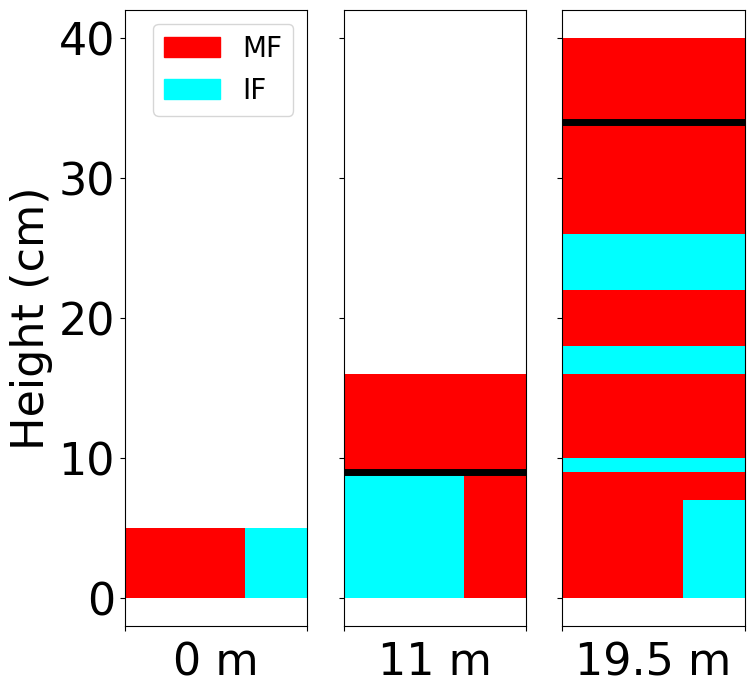

In [102]:
grain_color = {
    'MF': '#FF0000',
    'IF': '#00FFFF',
}


f, axs = plt.subplots(1, 3, sharey=True, figsize=(8, 8))

pos = 0
key = ('2024-06-07 00:00:00', 'ice', 'ice-20240607-a', pos)
plot_snowpit_column(axs[0], df, key)
axs[0].set_xlabel(str(pos) + ' m')
axs[0].xaxis.set_ticklabels([])

pos = 11
key = ('2024-06-07 00:00:00', 'ice', 'ice-20240607-a', pos)
plot_snowpit_column(axs[1], df, key)
axs[1].set_xlabel(str(pos) + ' m')
axs[1].xaxis.set_ticklabels([])

pos = 19.5
key = ('2024-06-07 00:00:00', 'ice', 'ice-20240607-a', pos)
plot_snowpit_column(axs[2], df, key)
axs[2].set_xlabel(str(pos) + ' m')
axs[2].xaxis.set_ticklabels([])

axs[0].set_ylabel('Height (cm)')

# Create legend
handles = []
for key, value in grain_color.items():
    handles.append(mpatches.Patch(color=value, label=key))

axs[0].legend(handles=handles, fontsize=20)

f.savefig(os.path.join('..','figures','amss_3shades_2025.png'), bbox_inches='tight')

In [103]:
axs[0].get_ylim()

(-2.0000000000000004, 42.00000000000001)

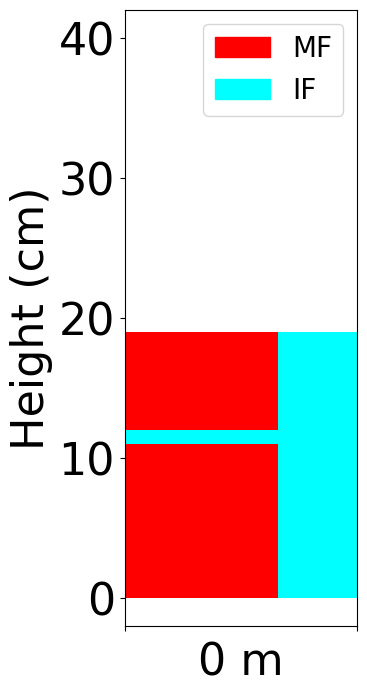

In [104]:
grain_color = {
    'MF': '#FF0000',
    'IF': '#00FFFF',
}


f, axs = plt.subplots(1, 1, sharey=True, figsize=(3, 8))
axs = [axs]

pos = 0
key = ('2024-06-18 00:00:00', 'ice', 'ice-20240618-a', pos)
plot_snowpit_column(axs[0], df, key)
axs[0].set_xlabel(str(pos) + ' m')
axs[0].xaxis.set_ticklabels([])

axs[0].set_ylabel('Height (cm)')

# Create legend
handles = []
for key, value in grain_color.items():
    handles.append(mpatches.Patch(color=value, label=key))

axs[0].legend(handles=handles, fontsize=20)
axs[0].set_ylim([-2, 42])

f.savefig(os.path.join('..','figures','amss_pondsamp_2025.png'), bbox_inches='tight')

In [13]:
df.index

MultiIndex([('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-16 00:00:00', 'arm', 'arm-20240416-a',     0),
            ('2024-04-17 00:00:00', 'ice', 'ice-20240417-a',     0),
            ('2024-04-17 00:00:00', 'ice', 'ice-20240417-a',     0),
            ...
            ('2024-06-18 00:00:00', 'ice', 'ice-20240618-a',     0),
            ('2024-06-18 00:00:00', 'ice', 'ice-20240618-a',     0),
            ('2024-06-18 00:00:00', 'ice', 'ice-20240618-a',     0),
            ('2024-06-18 00:00:00', 'ice', 'ice-20240618-a',     0),
            ('2024